<a href="https://colab.research.google.com/github/AlexDuchnowski/logo-gen/blob/main/description_clustering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# Proprocess on the description
WINDOW_SIZE = 16
1. translate the text
2. remove the punctuation
3. remove the stopwords
4. get the pretraining embedding matrix

In [ ]:
!pip install nltk
!pip install googletrans==3.1.0a0
!pip install gensim

     |████████████████████████████████| 55 kB 3.8 MB/s 
     |████████████████████████████████| 42 kB 1.7 MB/s 
     |████████████████████████████████| 1.3 MB 59.3 MB/s 
     |████████████████████████████████| 65 kB 4.1 MB/s 
     |████████████████████████████████| 53 kB 1.6 MB/s 
  Created wheel for googletrans: filename=googletrans-3.1.0a0-py3-none-any.whl size=16367 sha256=1643472bca2fd0f9e5d84006a484914088b75550a73d98f1fffb74b0d6a8a736
  Stored in directory: /root/.cache/pip/wheels/0c/be/fe/93a6a40ffe386e16089e44dad9018ebab9dc4cb9eb7eab65ae
Successfully built googletrans


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# # -*- coding: utf-8 -*-
# """
# word2vec embeddings start with a line with the number of lines (tokens?) and 
# the number of dimensions of the file. This allows gensim to allocate memory 
# accordingly for querying the model. Larger dimensions mean larger memory is 
# held captive. Accordingly, this line has to be inserted into the GloVe 
# embeddings file.
# """

import os
import shutil
import smart_open
from sys import platform

import gensim


def prepend_line(infile, outfile, line):
# 	""" 
# 	Function use to prepend lines using bash utilities in Linux. 
# 	(source: http://stackoverflow.com/a/10850588/610569)
# 	"""
  with open(infile, 'r') as old:
    with open(outfile, 'w') as new:
      new.write(str(line) + "\n")
      shutil.copyfileobj(old, new)

def prepend_slow(infile, outfile, line):
# 	"""
# 	Slower way to prepend the line by re-creating the inputfile.
# 	"""
	with open(infile, 'r') as fin:
		with open(outfile, 'w') as fout:
			fout.write(line + "\n")
			for line in fin:
				fout.write(line)

def get_lines(glove_file_name):
#     """Return the number of vectors and dimensions in a file in GloVe format."""
    with smart_open.smart_open(glove_file_name, 'r') as f:
        num_lines = sum(1 for line in f)
    with smart_open.smart_open(glove_file_name, 'r') as f:
        num_dims = len(f.readline().split()) - 1
    return num_lines, num_dims
	
# # Input: GloVe Model File
# # More models can be downloaded from http://nlp.stanford.edu/projects/glove/
glove_file="/content/drive/Shared drives/DL Final Project/Code/Data/glove.6B.50d.txt"

num_lines, dims = get_lines(glove_file)

# # Output: Gensim Model text format.
gensim_file='glove_model2.txt'
gensim_first_line = "{} {}".format(num_lines, dims)

# # Prepends the line.
if platform == "linux" or platform == "linux2":
	prepend_line(glove_file, gensim_file, gensim_first_line)
else:
	prepend_slow(glove_file, gensim_file, gensim_first_line)

# Demo: Loads the newly created glove_model.txt into gensim API.
model=gensim.models.KeyedVectors.load_word2vec_format(gensim_file,binary=False) #GloVe Model

## Preprocess on the description

In [ ]:
import numpy as np
import h5py
import tensorflow as tf
import matplotlib.pyplot as plt
import json

import googletrans 
from gensim.models import Word2Vec
from gensim.test.utils import common_texts
import nltk
import re
from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.download('punkt')
from nltk.tokenize import word_tokenize
from gensim.models.keyedvectors import KeyedVectors
import gensim

WINDOW_SIZE = 12
description_text = {}

# cann't drop the last few
def make_input_generator(data_file_path, batch_size, epochs):
    """
    Returns a generator on batches of data.
    :param data_file_path: file path to the hdf5 file containing the data
    :param batch_size: batch size for splitting up the model inputs
    :return: the final generator yields (images, descriptions, names)
    """
    hdf5_file = h5py.File(data_file_path, 'r')
    for n in range(epochs):
        for i in range(0, len(hdf5_file['data']), batch_size):
            end = i + batch_size
            if i + batch_size >= len(hdf5_file['data']):
              end = len(hdf5_file['data'])         
            users = [json.loads(user_json) for user_json in hdf5_file['meta_data']['twitter']['user_objects'][i:end]]
            descriptions = [user['description'] for user in users]   
            descriptions = process_descriptions(descriptions)
            yield  descriptions


def process_descriptions(descriptions):
    # create vocab for descriptions and replace words with corresponding ids (maybe UNK some words)
    # REPLACE WITH REAL PREPROCESSING
    translator = googletrans.Translator()
    padded_descriptions = None
    count = 0
    for desc in descriptions:
        count = count + 1
        description_text[str(count)] = desc
        description = translator.translate(desc).text
        description = re.sub(r'[^\w\s]', '', description).lower()
        description = word_tokenize(description)
        description = [t for t in description if t not in stopwords.words("english") and t in model.wv]
        if len(description) < WINDOW_SIZE:
            description.extend(['0' for _ in range(WINDOW_SIZE - len(description))])
        else:
            description = description[:WINDOW_SIZE]
        description = [model.wv[t] for t in description]
        if padded_descriptions is None:
          padded_descriptions = np.array(description).reshape(1,600)
        else:
          padded_descriptions = np.append(padded_descriptions, np.array(description).reshape(1,600), axis = 0)
    print(padded_descriptions.shape)
    return padded_descriptions

gen = make_input_generator('/content/drive/Shared drives/DL Final Project/Code/Data/LLD-logo.hdf5', 128, epochs=1)
embeddings =  next(gen)
while True:
  try:
    descriptions = next(gen)
    embeddings = np.append(embeddings, descriptions, axis = 0)
  except StopIteration as e:
    break

print(embeddings.shape)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:59: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).


(128, 600)
(128, 600)
(128, 600)
(128, 600)


KeyboardInterrupt: ignored

In [ ]:
print(tf.shape(embeddings))

## Description Clustering

### Import and Mount

In [ ]:
from tensorflow.keras.applications.resnet_v2 import ResNet50V2, preprocess_input
from tensorflow.keras.models import Model
from sklearn.decomposition import PCA
import tensorflow as tf
import numpy as np
import random
import heapq as hq
import h5py


### Kmeans

In [ ]:
#129000*12*50 => 

In [ ]:
class Kmeans(object):
    """
    K-Means Classifier via Iterative Improvement

    @attrs:
        k: The number of clusters to form as well as the number of centroids to
           generate (default = 10), an int
        tol: Value specifying our convergence criterion. If the ratio of the
             distance each centroid moves to the previous position of the centroid
             is less than this value, then we declare convergence.
        max_iter: the maximum number of times the algorithm can iterate trying
                  to optimize the centroid values, an int,
                  the default value is set to 500 iterations
        centroids: a Numpy array where each element is one of the k cluster centers
    """

    def __init__(self, num_clusters = 16, max_iter = 2000, threshold = 1e-7):
        """
        Initiate K-Means with some parameters
        """
        self.k = num_clusters
        self.tol = threshold
        self.max_iter = max_iter
        self.centroids = None

    def train(self, X):
        """
        Compute K-Means clustering on each class label and store your result in self.cluster_centers_
        :param X: inputs of training data, a 2D Numpy array
        """
        curr_centroids = np.array(random.sample(X.tolist(), self.k))
        prev_centroids = curr_centroids
        iter = 0
        while(iter < self.max_iter):
            # assigning cluster for each images
            assigned_data = np.array([np.argmin(np.sum(np.square(curr_centroids-x), axis=1)) for x in X])
            # 
            curr_centroids = np.array([np.average(X[np.where(assigned_data==i)],axis=0) for i in range(self.k)])
            if (np.linalg.norm(curr_centroids-prev_centroids)/np.linalg.norm(prev_centroids) < self.tol):
                break
            prev_centroids = curr_centroids
            iter += 1
            #print(f"kmeans iteration number {iter} done")
        self.centroids = curr_centroids
        # m = 64
        # closest_data = []
        # for centroid in self.centroids:
        #     pq=[]
        #     for i in range(len(X)):
        #         hq.heappush(pq, (np.sum(np.square(centroid-X[i])), i))
        #     temp_data = []
        #     for i in range(m):
        #         temp_data.append(hq.heappop(pq)[1])
        #     closest_data.append(temp_data)
        # np.savetxt(f"/content/drive/Shared drives/DL Final Project/Code/Clusters/icon/{self.k}_best_clusters_data.csv", closest_data, delimiter=",")
        # print(f"save best clusters image for {self.k}")

    def predict(self, X):
        """
        Predicts the label of each sample in X based on the assigned centroids.

        :param X: A dataset as a 2D Numpy array
        :return: A Numpy array of predicted clusters
        """
        return np.array([np.argmin(np.sum(np.square(self.centroids-x), axis=1)) for x in X])


## K mean clusifier

In [ ]:
num_clusters=[4,6,8,10,12,16,24,32,64]
for num_cluster in num_clusters:
    classifier = Kmeans(num_clusters=num_cluster)
    classifier.train(embeddings)
    print(f"done kmeans trainning with {num_cluster} clusters")
    description_clusters = np.reshape(classifier.predict(embeddings), (-1,1))
    # Return the clusters with same indices as image data
    np.savetxt(f"/content/drive/Shared drives/DL Final Project/Code/Clusters/logo/description_cluster_{num_cluster}.csv", description_clusters, delimiter=",")
    
    

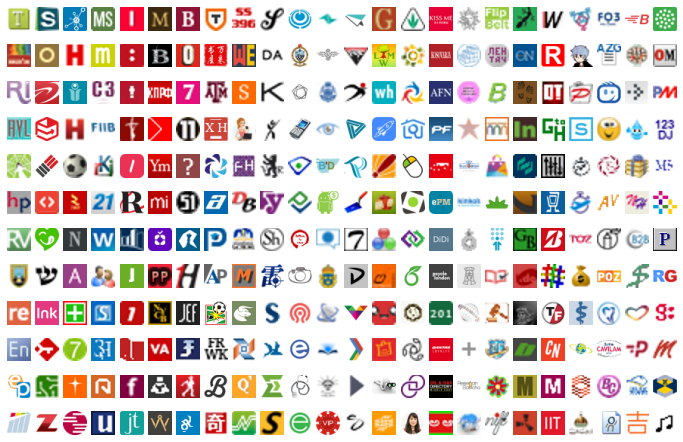

In [ ]:
from matplotlib import pyplot as plt
import h5py
import csv

NUM_CLUSTERS = 24
N_ROW = NUM_CLUSTERS
N_COL = 12

data_file_path = '/content/drive/Shared drives/DL Final Project/Code/Data/LLD-icon.hdf5'
cluster_file_path = f'/content/drive/Shared drives/DL Final Project/Code/Clusters/icon/{NUM_CLUSTERS}_best_clusters_data.csv'

image_data = h5py.File(data_file_path, 'r')['data']
cluster_data = []
with open(cluster_file_path, 'r') as f:
    for row in csv.reader(f):
        cluster_data.append([int(float(v)) for v in row])

def getImage(image):
    return tf.cast(tf.transpose(image, [1, 2, 0]), tf.int32)

fig = plt.figure(figsize=(12, 8))
for c in range(NUM_CLUSTERS):
    #idx = np.random.choice(np.where(cluster_data==c)[0], N_COL)
    idx = cluster_data[c]
    for r in range(N_COL):
        image = image_data[idx[r]]
        fig.add_subplot(N_COL, N_ROW, r*N_ROW+c+1)
        plt.imshow(getImage(image))
        plt.axis('off')

#plt.imshow(data, interpolation='nearest')


In [ ]:
from matplotlib import pyplot as plt
import h5py
import csv

NUM_CLUSTERS = 24
N_ROW = NUM_CLUSTERS
N_COL = 12

data_file_path = '/content/drive/Shared drives/DL Final Project/Code/Data/LLD-icon.hdf5'
cluster_file_path = f'/content/drive/Shared drives/DL Final Project/Code/Clusters/icon/{NUM_CLUSTERS}_clusters_data.csv'


#image_data = h5py.File(data_file_path, 'r')['data']
c = 26
cluster_data = []
count = np.zeros(NUM_CLUSTERS)
with open(cluster_file_path, 'r') as f:
    for row in csv.reader(f):
        #cluster_data.append([int(float(v)) for v in row])
        for i in range(NUM_CLUSTERS):
            if int(float(row[0])) == i:
                count[i] += 1

print(count)

[27578. 11701. 15171. 28161.  5860. 12575. 11604. 14136. 25880. 13346.
  8257. 26064.  9204. 23430. 12725.  9849. 37593. 41012. 13487. 15804.
 24175. 27717. 45062. 25986.]
